```
conda create --prefix /global/cscratch1/sd/saksman/accda_conda/ --file MAS.txt
conda activate /global/cscratch1/sd/saksman/accda_conda
pip install imageio umap matplotlib faiss-gpu tensorflow-addons==0.9.1 numpy==1.19.5 tensorflow==2.2
pip install tensorflow_gpu==1.15.5
python3 -m ipykernel install --user --name=accda
```

In [20]:
pip install -U tensorflow

     |████████████████████▊           | 296.0 MB 170.3 MB/s eta 0:00:01

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 458.3 MB 56 kB/s 
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached clang-5.0.tar.gz (30 kB)
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
     |████████████████████████████████| 4.0 MB 132.9 MB/s eta 0:00:01
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
     |████████████████████████████████| 5.6 MB 24.5 MB/s eta 0:00:01
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=eabfaa576a15a2d39578aa955a4f079b3d44ab55c6e6ed160a3ce07c6e5a2d4b
  Stored in directory: /global/u2/s/saksman/.cache/pip/wheels/22/4c/94/0583f60c9c5b6024ed64f290cb2d43b06bb4f75577dc3c93a7
  Created wheel for wrapt: filename=wrapt-1.12.1-cp36-cp36m-linux_x86_64.whl size=70495 sha256=d05b97d6c79546

In [ ]:
# https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# https://stackoverflow.com/questions/56008683/could-not-create-cudnn-handle-cudnn-status-internal-error
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
# tf.compat.v1.enable_eager_execution()

In [ ]:
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

#tensorflow 2.6 kernel

In [15]:
import importlib

import wasserstein_utils
import data_utils
import losses
import networks
import deeplabv3 as dlv3
import utils

import matplotlib.pyplot as plt


# End-End training and testing of the new pytorch-based VGG16-deeplabv3 architecture
# https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# https://stackoverflow.com/questions/56008683/could-not-create-cudnn-handle-cudnn-status-internal-error
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
# tf.compat.v1.enable_eager_execution()
import importlib
import matplotlib.pyplot as plt
# import wasserstein_utils
import data_utils
import losses
import networks
import deeplabv3 as dlv3
import utils
import pickle
import time
import numpy as np
import importlib

import faiss

import data_utils
import losses

from IPython import display
import umap


In [1]:
import time
import numpy as np

import data_utils
import data_utils_new
import losses

from IPython import display

In [2]:
backbone = 'vgg16'
dataset = "SYNTHIA_VIPER_DENSE_13_1"

# H x W x C
img_shape = (512,1024,3)

# 13 classes + void
num_classes = 14

batch_size=4

do_training = True

epochs=100000
epoch_step=250

num_projections=100

source_data_dir = '/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/SYNTHIA/train/'
cityscapes_data_dir = '/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence001/'

fn_w_dlv3 = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + "/" + backbone + "_deeplabv3.h5"
fn_w_cls = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + "/" + backbone + "_deeplabv3_classifier.h5"

fn_w_adapted_dlv3 = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + "/" + backbone +"_deeplabv3_adapted.h5"
fn_w_adapted_cls = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + "/" + backbone + "_deeplabv3_classifier_adapted.h5"

In [3]:
print(fn_w_dlv3)
print(fn_w_adapted_dlv3)

/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3.h5
/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_adapted.h5


In [8]:
importlib.reload(losses)

deeplabv3 = dlv3.deeplabv3(activation=None, \
                           backbone=backbone, \
                           num_classes=num_classes)

X = deeplabv3.input
Y = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,), dtype='float32', name='label_input')

C_in = tf.keras.layers.Input(shape=deeplabv3.layers[-1].output_shape[1:], dtype='float32', name='classifier_input')
classifier = tf.keras.Model(C_in, networks.classifier_layers(C_in, num_classes = num_classes, activation='softmax'))

# A combined model, giving the output of classifier(deeplabv3(X))
combined = tf.keras.Model(X, classifier(deeplabv3(X)))
combined.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))

# A model outputting hxwx1 labels for each image. Also useful to verify the
# mIoU with Keras' built-in function. Will however also consider the 'ignore' class. 
combined_ = tf.keras.Model(X, tf.cast(tf.keras.backend.argmax(combined(X), axis=-1), 'float32'))
combined_.compile(metrics=[tf.keras.metrics.MeanIoU(num_classes=num_classes)], loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False))

# Set up training
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-8, decay=1e-6)
# opt = tf.keras.optimizers.SGD(lr=1e-4, momentum=.9)

loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss = loss_function(Y, classifier(deeplabv3(X)), from_logits=False)

# https://stackoverflow.com/questions/55434653/batch-normalization-doesnt-have-gradient-in-tensorflow-2-0
params = deeplabv3.trainable_weights + classifier.trainable_weights

updates = opt.get_updates(wce_loss, params)

train = tf.keras.backend.function(inputs=[X,Y], outputs=[wce_loss], updates=updates)

In [ ]:
# deeplabv3.load_weights(fn_w_dlv3)
# classifier.load_weights(fn_w_cls)

In [9]:
# import matplotlib.pyplot as plt 
# importlib.reload(data_utils)

# do_training = True

# # Training on source domain
# if do_training == True:
#     try:
#         deeplabv3.load_weights(fn_w_dlv3)
#         classifier.load_weights(fn_w_cls)

#         print("Successfully loaded model. Continuing training.")
#     except:
#         print("Could not load previous model weights. Is a new model present?")
        
#     start_time = time.time()

#     fig,ax = plt.subplots(1,figsize=(10,7))

#     loss_history = []

#     for itr in range(epochs):
#     # for itr in range(1):
#         source_train_data, source_train_labels = utils.sample_batch(source_data_dir, batch_size=batch_size, seed=itr)
#         source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)

#         loss_history.append(train(inputs=[source_train_data, source_train_labels ]))

#         if np.isnan(np.sum(loss_history[-1])):
#             print('ERROR. ENCOUNTERED NAN')
#             break

#         if itr%epoch_step == 0:
#             if itr != 0:
#                 ax.clear()
#                 ax.plot(np.asarray(loss_history))

#             ax.set_title("Training loss on source domain")
#             ax.set_xlabel("Epoch")
#             ax.set_ylabel("Loss")

#             display.clear_output(wait=True)
#             display.display(plt.gcf())
#             time.sleep(1e-3)
            
#         if itr % (epochs // 10) == 0 or itr == epochs - 1:
#             deeplabv3.save_weights(fn_w_dlv3)
#             classifier.save_weights(fn_w_cls)

#     training_time = time.time() - start_time
# else:
#     deeplabv3.load_weights(fn_w_dlv3)
#     classifier.load_weights(fn_w_cls)
#     print("Loaded model weights")

In [12]:
deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')
print("Loaded model weights")

Loaded model weights


## Performance before adaptation

In [ ]:
import utils
importlib.reload(utils)

import data_utils_new

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils_new.label_ids_13, [])

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)


# road 0.8615078545158885
# sidewalk 0.9000774695735323
# building 0.9430844244367906
# traffic light 0.5906543878603067
# traffic sign 0.47512503948229323
# vegetation 0.8432760653705371
# sky 0.9643722032928421
# person 0.7238042430944608
# rider 0.6191497998404211
# car 0.882677391642491
# bus 0.911323854999263
# motorcycle 0.6885880663029611
# bicycle 0.34777010181426876
# 0.7501085309404659
# Computed SYNTHIA_VIPER_DENSE_13_1 mIoU in 3522.347924232483

In [12]:
importlib.reload(utils)

start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils_new.label_ids_13, [])

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed VIPER mIoU in', time.time() - start_time)

# road 0.46610276620252705
# sidewalk 0.08673575303732681
# building 0.47584591747660204
# traffic light 0.09605701550329426
# traffic sign 0.014402255800938481
# vegetation 0.13339936275003222
# sky 0.7302335987742893
# person 0.19711547556738282
# rider 0.0
# car 0.8627417161587038
# bus 0.01936740214450999
# motorcycle 0.0
# bicycle 0.0
# 0.237077020262739
# Computed VIPER mIoU in 166.7798900604248

ignore 0.0
road 0.46600550969361687
sidewalk 0.08673386139638939
building 0.47567657106939204
traffic light 0.096038243034673
traffic sign 0.014404219487528921
vegetation 0.13340190671890303
sky 0.7299059721207719
person 0.1971218314328171
rider 0.0
car 0.8628852727742756
bus 0.01935999478079332
motorcycle 0.0
bicycle 0.0
0.22010952732208294
Computed VIPER mIoU in 394.8119444847107


### Load pretrained weights for SYNTHIA

In [ ]:
# deeplabv3.load_weights("/pscratch/sd/c/chubakov/code/mas3-continual/weights/SYNTHIA_VIPER_DENSE_13_3/vgg16_deeplabv3_adapted.h5")
# classifier.load_weights("/pscratch/sd/c/chubakov/code/mas3-continual/weights/SYNTHIA_VIPER_DENSE_13_3/vgg16_deeplabv3_classifier_adapted.h5")
# print("Loaded model weights")

In [ ]:
import data_utils_new
importlib.reload(utils)

start_time = time.time()
means, _, ct = utils.learn_gaussians(source_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13)
print("computed means in", time.time() - start_time)

start_time = time.time()
means, covs, ct = utils.learn_gaussians(source_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13, \
                                  initial_means=means)
print("finished training gaussians in", time.time() - start_time)

np.save("./extras/means_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy", means)
np.save("./extras/covs_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy", covs)

In [ ]:
for i in range(means.shape[0]):
    print('=====================================================')
    print(means[i])
    print(covs[i])


In [ ]:
# means = np.load("./extras/means_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy")
# covs = np.load("./extras/covs_1024x512_" + backbone + "deeplabv3_" + dataset + ".npy")

# means = np.load("./extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_COMBINED_13.npy")
# covs = np.load("./extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_COMBINED_13.npy")

In [29]:
# SYNTHIA -> VIPER1
means = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
covs = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")



means = np.nan_to_num(means)

In [9]:
means = np.load("./extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
covs = np.load("./extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")

In [10]:
# means = np.load("./extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_COMBINED_13.npy")
# covs = np.load("./extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_COMBINED_13.npy")
means = np.nan_to_num(means)
# means

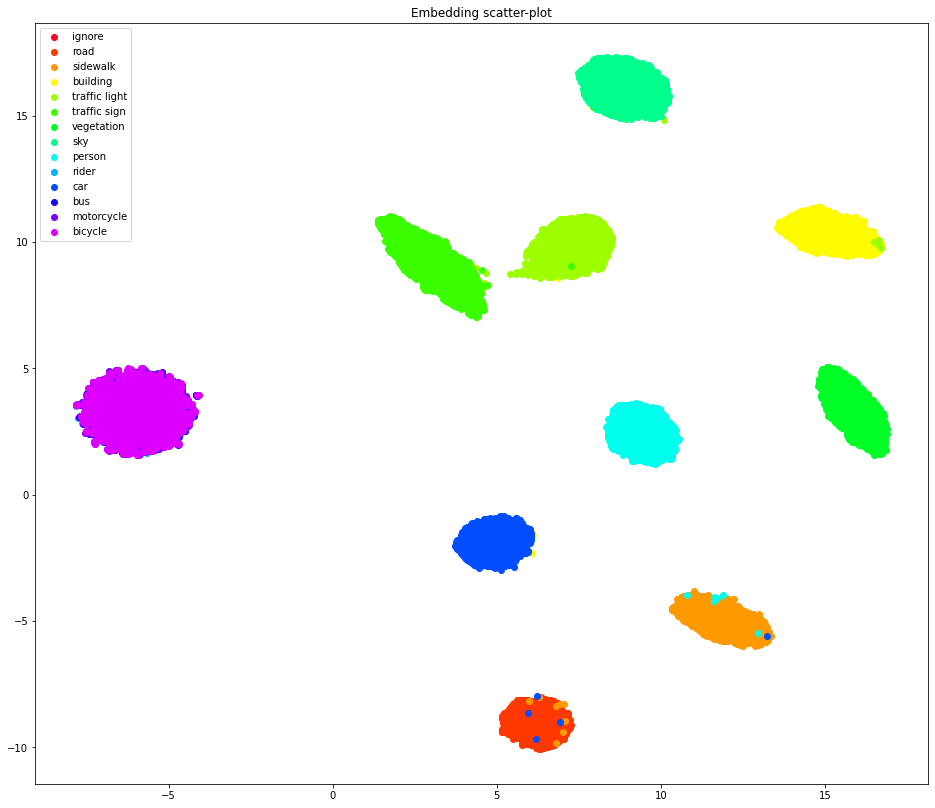

18.559155464172363


In [11]:
import data_utils_new
import matplotlib.pyplot as plt 
import umap.umap_ as umap
# Generate data from the gmm model and plot it

start_time = time.time()

n_samples = np.ones(num_classes, dtype=int)
n_samples[0] = 0
n_samples *= 2000

xx, yy = utils.sample_from_gaussians(means, covs, n_samples=n_samples)

NUM_COLORS = num_classes

reducer = umap.UMAP()

umap_embedding = reducer.fit_transform(xx)

plt.figure(figsize=(16,14))
cm = plt.get_cmap('gist_rainbow')

shift = 1 / len(data_utils_new.label_ids_13.keys())
idx = 0
for label in data_utils_new.label_ids_13:
    ind = yy == data_utils_new.label_ids_13[label]
    
    plt.scatter(umap_embedding[:,0][ind], umap_embedding[:,1][ind], label=label, \
                color=cm(1.*idx/NUM_COLORS))
    idx += 1

plt.title("Embedding scatter-plot")
plt.legend()
    
plt.show()

print(time.time() - start_time)

## Initalize loss function 

In [9]:
# importlib.reload(wasserstein_utils)
import tensorflow_addons as tfa

Z_s = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,) )
X_labeled = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], 3,) )
Y_s = tf.keras.backend.placeholder(shape=(None, img_shape[0], img_shape[1], num_classes), dtype='float32') # labels of input images oneHot
Y_labeled = tf.keras.backend.placeholder(shape=(None, img_shape[0], img_shape[1], num_classes), dtype='float32') # labels of input images oneHot
lambda1 = 1
lambda2 = 5e-1
lambda3 = 5e-1
    
loss_function = losses.weighted_ce_loss(num_classes, 0)
wce_loss_labeled = loss_function(Y_labeled, classifier(deeplabv3(X_labeled)), from_logits=False)
wce_loss_unlabeled = loss_function(Y_s, classifier(Z_s), from_logits=False)

# Wasserstein matcing loss
# theta = tf.keras.backend.placeholder(shape = (num_projections, num_classes), dtype='float32')
# matching_loss = wasserstein_utils.sWasserstein_hd(deeplabv3(X), deeplabv3(Z_s), theta, nclass=num_classes, Cp=None, Cq=None,)

# Overall loss is a weighted combination of the losses
# total_loss = lambda1 * wce_loss_unlabeled + lambda2 * wce_loss_labeled + lambda3 * matching_loss
total_loss = lambda1 * wce_loss_unlabeled + lambda2 * wce_loss_labeled
# total_loss = lambda2 * wce_loss_labeled

params = deeplabv3.trainable_weights + classifier.trainable_weights

# Optimizer and training setup
opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-6, decay=1e-6)
# use SGD w/ weight decay
# opt = tfa.optimizers.SGDW(learning_rate=0.0001, momentum=0.9, weight_decay=2.0e-4, name='SGDW')

updates = opt.get_updates(total_loss, params)
train = tf.keras.backend.function(inputs=[X,  Z_s, Y_s, X_labeled, Y_labeled], 
                                  outputs=[total_loss, wce_loss_labeled, wce_loss_unlabeled], updates=updates)

# train = tf.keras.backend.function(inputs=[X, Z_s, Y_s, theta, X_labeled, Y_labeled], 
#                                   outputs=[total_loss, wce_loss_labeled, wce_loss_unlabeled, matching_loss], updates=updates)

In [9]:
# old loss function code
# importlib.reload(wasserstein_utils)

# Z_s = tf.keras.layers.Input(shape=(img_shape[0], img_shape[1], num_classes,) )
# Y_s = tf.keras.backend.placeholder(shape=(None, img_shape[0], img_shape[1], num_classes), dtype='float32') #labels of input images oneHot
# lambda2 = 5e-1

# loss_function = losses.weighted_ce_loss(num_classes, 0)
# wce_loss = loss_function(Y_s, classifier(Z_s), from_logits=False)

# # Wasserstein matcing loss
# theta = tf.keras.backend.placeholder(shape = (num_projections, num_classes), dtype='float32')
# matching_loss = wasserstein_utils.sWasserstein_hd(deeplabv3(X), Z_s, theta, nclass=num_classes, Cp=None, Cq=None,)

# # Overall loss is a weighted combination of the two losses
# total_loss = wce_loss + lambda2*matching_loss

# params = deeplabv3.trainable_weights + classifier.trainable_weights

# # Optimizer and training setup
# opt = tf.keras.optimizers.Adam(lr=1e-4, epsilon=1e-6, decay=1e-6)

# updates = opt.get_updates(total_loss, params)
# train = tf.keras.backend.function(inputs=[X,Z_s,Y_s,theta], outputs=[total_loss, wce_loss, matching_loss], updates=updates)

/global/common/software/nersc/shasta2105/tensorflow/2.6.0/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients_1/gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("Adam/gradients_1/gradients/GatherV2_grad/Reshape:0", shape=(None, 100), dtype=float32), dense_shape=Tensor("Adam/gradients_1/gradients/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/global/common/software/nersc/shasta2105/tensorflow/2.6.0/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients_1/gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("Adam/gradients_1/gradients/GatherV2_1_grad/Reshape:0", shape=(None, 100), dtype=float32), dense

In [9]:
deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')
print("Loaded model weights")

Loaded model weights


## Source clustering & active target sample selection

In [10]:
import heapq

def calculate_mean_vector(images, labels, vector_size, num_classes):
    n = len(images)
    full_objective_vector = np.zeros([n, num_classes, vector_size]) 
    i = 0
    for i in range(len(images)):
        image = np.expand_dims(images[i], axis=0)
        f_E = deeplabv3(image)[0, :, :, :]
        F_x = np.zeros((num_classes, vector_size)) # feature map for this image
        for c in range(0, num_classes - 1): 
            F_c_x = tf.math.multiply(f_E[:,:,c], labels[i][:,:,c]) / np.sum(labels[i][:,:,c])
            F_c_x_expanded = np.expand_dims(np.expand_dims(F_c_x, axis=0), axis=3)
            F_c_x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(32, 64), padding='valid')(F_c_x_expanded)
            F_c_x = tf.reshape(F_c_x, [-1])
            F_x[c] = F_c_x
        full_objective_vector[i, :] = F_x
        print(i)
        i += 1
    return full_objective_vector
    
import faiss

def run_kmeans(x, nmb_clusters, ngpu, weighted=False, verbose=False):
    """Runs kmeans on 1 or more GPUs.
    Args:
        x: data
        nmb_clusters (int): number of clusters
        ngpu: number of available gpus
        weighted: bool, indicates whether to use weighted K-means
    Returns:
        list: ids of data in each cluster
    """
    n_data, d = x.shape
    
    def H(x):
        return -(x * np.log2(x, where=x > 0)).sum(1)
    
    # faiss implementation of k-means
    clus = faiss.Clustering(d, nmb_clusters)

    # Change faiss seed at each k-means so that the randomly picked
    # initialization centroids do not correspond to the same feature ids
    # from an epoch to another.
    clus.seed = np.random.randint(1234)

    clus.niter = 20
    clus.max_points_per_centroid = 10000000
    res = [faiss.StandardGpuResources() for i in range(ngpu)]
    flat_config = []
    for i in range(ngpu):
        cfg = faiss.GpuIndexFlatConfig()
        cfg.useFloat16 = False
        cfg.device = i
        flat_config.append(cfg)
        
    if ngpu == 1:
        index = faiss.GpuIndexFlatL2(res[0], d, flat_config[0])
    else:
        indexes = [faiss.GpuIndexFlatL2(res[i], d, flat_config[i])
                   for i in range(ngpu)]
        index = faiss.IndexReplicas()
        for sub_index in indexes:
            index.addIndex(sub_index)
    if weighted:
        weights = H(x)
        print(weights.shape)
        clus.train(x, index, weights=weights)
    else:
        clus.train(x, index)

    _, I = index.search(x, 1)
    stats = clus.iteration_stats
    losses = np.array([
        stats.at(i).obj for i in range(stats.size())
    ])
    if verbose:
        print('k-means loss evolution: {0}'.format(losses))
    centroids = faiss.vector_float_to_array(clus.centroids)

    return centroids, [int(n[0]) for n in I], losses[-1]

def get_active_XY(images, pred_labels, actual_labels, vector_size, batch_size, sampling_rate, num_classes, strategy = "ours"):
    ''' calculate active learning criteria and returns vectors for training and list of selected indices'''
    
    if strategy == "random":
        selected_idx = np.random.choice(batch_size, int(batch_size * sampling_rate), replace=False)
    elif strategy in ("mada", "ours"):
        al_list = []
        n = len(images)
        full_objective_vector = np.zeros([n, num_classes, vector_size]) 
        selected_n = int(sampling_rate * n)
        
        # if strategy == "ours":
        #     full_objective_vector = calculate_mean_vector(images, pred_labels, vector_size)
        #     full_objective_vector = np.nan_to_num(np.reshape(full_objective_vector, (full_objective_vector.shape[0], 
        #                                              full_objective_vector.shape[1] * full_objective_vector.shape[2])).astype('float32'), nan=0.0)
        #     cluster_centroids, cluster_index, cluster_loss = run_kmeans(full_objective_vector, nmb_clusters=10, ngpu=ngpu, weighted=True, verbose=False)
        #     cluster_centroids = cluster_centroids.reshape(ncentroids, 20, 256)
        
        for i in range(len(images)):
            # try:
            image = np.expand_dims(images[i], axis=0)
            f_E = deeplabv3(image)[0, :, :, :]
            F_x = np.zeros((num_classes, vector_size)) # feature map for this image
            for c in range(0, num_classes - 1): 
                F_c_x = tf.math.multiply(f_E[:,:,c], pred_labels[i][:,:,c]) / np.sum(pred_labels[i][:,:,c])
                F_c_x_expanded = np.expand_dims(np.expand_dims(F_c_x, axis=0), axis=3)
                F_c_x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(32, 64), padding='valid')(F_c_x_expanded)
                F_c_x = tf.reshape(F_c_x, [-1])
                F_x[c] = F_c_x
            # calculate active learning criteria
            loss = []
            for centroid in cluster_centroids:
                new_loss = np.nanmean((F_x - centroid) ** 2)
                loss.append(new_loss)
            min_loss = min(loss)
            if strategy == "mada":
                al_list.append(min_loss)
            elif strategy == "ours":
                pred_labels_np = pred_labels.numpy()
                entropy_weight = np.mean(-(pred_labels_np * np.log2(pred_labels_np, where=pred_labels_np > 0)).sum())
                al_list.append(entropy_weight * min_loss)
        
        # find idx vals which maximize criteria
        selected_idx = list(map(al_list.index, heapq.nlargest(selected_n, al_list)))
            
        
    # return subset of images / labels for training
    X_labeled = []
    Y_labeled = []
    for idx in selected_idx:
        X_labeled.append(images[idx])
        Y_labeled.append(actual_labels[idx])
        
    X_eval = np.delete(images, selected_idx, 0)
    Y_eval = np.delete(actual_labels, selected_idx, 0)
        
    return np.asarray(X_labeled), np.asarray(Y_labeled), X_eval, Y_eval, selected_idx

## Clustering on source domain (SYNTHIA) for initial adaptation

In [12]:
np.random.seed(123)
ncentroids = 10
ngpu = 1
seed = 100

source_train_data, source_train_labels = utils.sample_batch(source_data_dir, batch_size=50, seed=seed)
source_train_labels = tf.keras.utils.to_categorical(source_train_labels, num_classes=num_classes)

vector_size = 256
full_objective_vector = calculate_mean_vector(source_train_data, source_train_labels, vector_size, num_classes)

tensor_sample = np.nan_to_num(np.reshape(full_objective_vector, (full_objective_vector.shape[0], full_objective_vector.shape[1] * full_objective_vector.shape[2])).astype('float32'), nan=0.0)
cluster_centroids, cluster_index, cluster_loss = run_kmeans(tensor_sample, ncentroids, ngpu, weighted=False, verbose=True)
with open('./anchors/cluster_centroids_full_%d.pkl' % ncentroids,'wb') as f: 
    pickle.dump(cluster_centroids, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
k-means loss evolution: [0.00413724 0.00367611 0.0035106  0.00341629 0.00331405 0.00322836
 0.00310121 0.00310121 0.00310121 0.00310121 0.00310121 0.00310121
 0.00310121 0.00310121 0.00310121 0.00310121 0.00310121 0.00310121
 0.00310121 0.00310121]


## Initial SYNTHIA->VIPER adaptation

In [11]:
loss = []
target_miou = []
# load model weights
# deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
# classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')

deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_adapted.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_classifier_adapted.h5')

print("Loaded model weights")

# load replay buffer params
means = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
means = np.nan_to_num(means)
covs = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
print("Loaded means and covariances for replay buffer")

Loaded model weights
Loaded means and covariances for replay buffer


mIoU at 19 epochs: 0.45033872586030227, best mIoU: 0.45033872586030227


KeyboardInterrupt: 

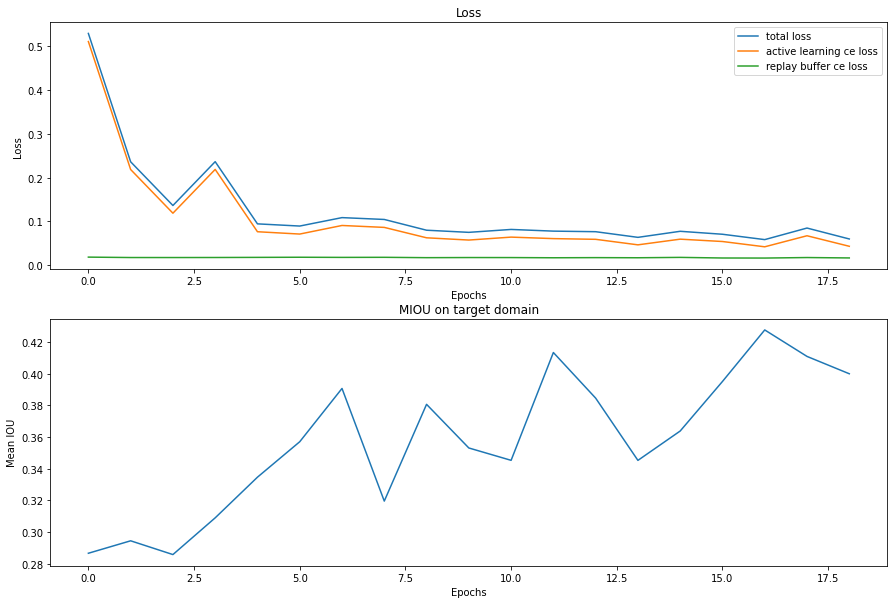

In [19]:
# active learning
# w/o  wasserstein loss
# Adam loss
# source clusters
import math 
fig, ax=plt.subplots(2, figsize=(15,10))

batch_size = 20

thres = .99
epochs2 = 20
epochstep = 2


# active learning set up 
ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, num_classes, 256)
print("Loaded cluster centroids for active learning")
print(cluster_centroids.shape)

best_miou = -math.inf
best_ious = []
active_learning = True
strategy = "ours"
all_selected_idx = []
for itr in range(epochs2):
    
    if itr%epochstep == 0:
        print('Iteration: {}'.format(itr))
    
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    # target_train_labels_cat = tf.keras.utils.to_categorical(target_train_labels, num_classes=num_classes)
     
    if active_learning and strategy is not None:
        pred_target_labels = deeplabv3(target_train_data)

        X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_XY(target_train_data, pred_target_labels, target_train_labels, 256, batch_size, 0.2, num_classes, strategy = strategy)
        Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
        all_selected_idx.append(selected_idx)
    else:
        pass # TODO: run unsupervised method here

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)

    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
    
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, X_labeled, Y_labeled]))
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 14/13
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
        best_combined = combined_
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            print(ll)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1] * lambda2, label='active learning ce loss')
            ax[0].plot(ll[:,2] * lambda1, label='replay buffer ce loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        deeplabv3.save_weights(fn_w_adapted_dlv3)
        classifier.save_weights(fn_w_adapted_cls)
        
        time.sleep(1e-3) 
        
    if itr == epochs2 - 1:
        # run for best epoch
        best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_13, ids_to_ignore = all_selected_idx)
        for k in best_cat_iou:
            print(k, best_cat_iou[k])
        print(best_miou2)

mIoU at 19 epochs: 0.518859441463764, best mIoU: 0.5465702276963454
ignore 0.0
road 0.8884529720768418
sidewalk 0.5858592801531234
building 0.6421096840253216
traffic light 0.538680884598599
traffic sign 0.014632960903552065
vegetation 0.34836145079767067
sky 0.9209314487803937
person 0.33810035465072164
rider 0.0
car 0.9839621513734922
bus 0.0
motorcycle 0.0
bicycle 0.0
0.3757922276685512


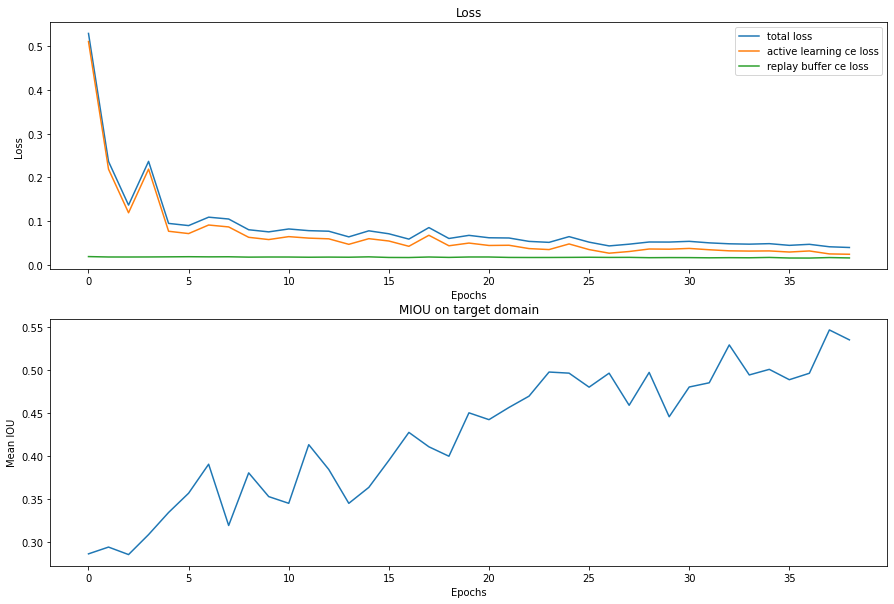

In [20]:
# active learning
# w/o  wasserstein loss
# Adam loss
# source clusters
import math 
fig, ax=plt.subplots(2, figsize=(15,10))

batch_size = 20

thres = .99
epochs2 = 20
epochstep = 2


# active learning set up 
ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, num_classes, 256)
print("Loaded cluster centroids for active learning")
print(cluster_centroids.shape)

best_miou = -math.inf
best_ious = []
active_learning = True
strategy = "ours"
all_selected_idx = []
for itr in range(epochs2):
    
    if itr%epochstep == 0:
        print('Iteration: {}'.format(itr))
    
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    # target_train_labels_cat = tf.keras.utils.to_categorical(target_train_labels, num_classes=num_classes)
     
    if active_learning and strategy is not None:
        pred_target_labels = deeplabv3(target_train_data)

        X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_XY(target_train_data, pred_target_labels, target_train_labels, 256, batch_size, 0.2, num_classes, strategy = strategy)
        Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
        all_selected_idx.append(selected_idx)
    else:
        pass # TODO: run unsupervised method here

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)

    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
    
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, X_labeled, Y_labeled]))
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 14/13
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
        best_combined = combined_
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            print(ll)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1] * lambda2, label='active learning ce loss')
            ax[0].plot(ll[:,2] * lambda1, label='replay buffer ce loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        deeplabv3.save_weights(fn_w_adapted_dlv3)
        classifier.save_weights(fn_w_adapted_cls)
        
        time.sleep(1e-3) 
        
    if itr == epochs2 - 1:
        # run for best epoch
        best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_13, ids_to_ignore = all_selected_idx)
        for k in best_cat_iou:
            print(k, best_cat_iou[k])
        print(best_miou2)

mIoU at 19 epochs: 0.5367304407633268, best mIoU: 0.5779664608148428
ignore 0.0
road 0.8927570572276865
sidewalk 0.5700248424532656
building 0.656345551854552
traffic light 0.5547702647577254
traffic sign 0.12167058060130395
vegetation 0.36339353637753247
sky 0.9189963498348828
person 0.3685971992311049
rider 0.0
car 0.981565333375478
bus 0.056599243742872576
motorcycle 0.0
bicycle 0.0
0.39176571138974314


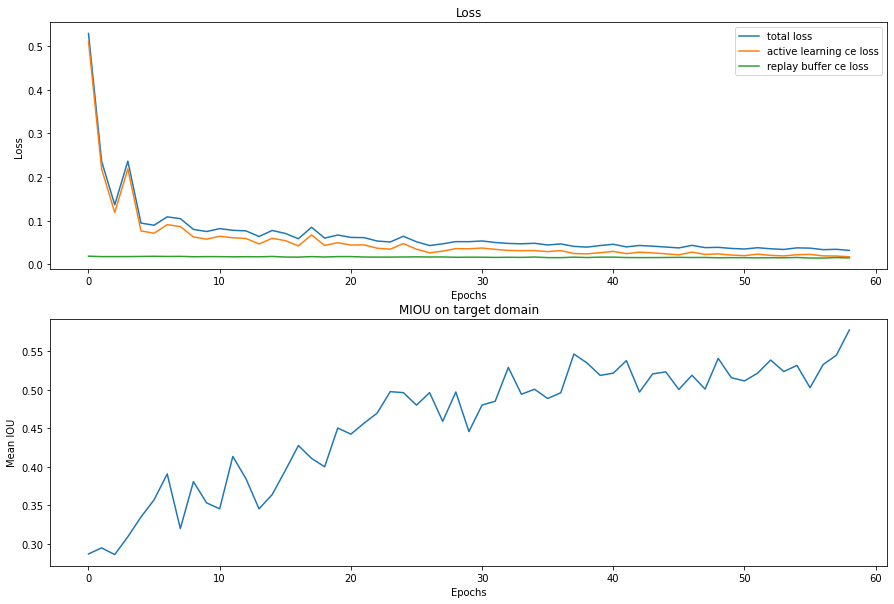

In [21]:
# active learning
# w/o  wasserstein loss
# Adam loss
# source clusters
import math 
fig, ax=plt.subplots(2, figsize=(15,10))

batch_size = 20

thres = .99
epochs2 = 20
epochstep = 2


# active learning set up 
ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, num_classes, 256)
print("Loaded cluster centroids for active learning")
print(cluster_centroids.shape)

best_miou = -math.inf
best_ious = []
active_learning = True
strategy = "ours"
all_selected_idx = []
for itr in range(epochs2):
    
    if itr%epochstep == 0:
        print('Iteration: {}'.format(itr))
    
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    # target_train_labels_cat = tf.keras.utils.to_categorical(target_train_labels, num_classes=num_classes)
     
    if active_learning and strategy is not None:
        pred_target_labels = deeplabv3(target_train_data)

        X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_XY(target_train_data, pred_target_labels, target_train_labels, 256, batch_size, 0.2, num_classes, strategy = strategy)
        Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
        all_selected_idx.append(selected_idx)
    else:
        pass # TODO: run unsupervised method here

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)

    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
    
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, X_labeled, Y_labeled]))
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 14/13
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
        best_combined = combined_
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            print(ll)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1] * lambda2, label='active learning ce loss')
            ax[0].plot(ll[:,2] * lambda1, label='replay buffer ce loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        deeplabv3.save_weights(fn_w_adapted_dlv3)
        classifier.save_weights(fn_w_adapted_cls)
        
        time.sleep(1e-3) 
        
    if itr == epochs2 - 1:
        # run for best epoch
        best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_13, ids_to_ignore = all_selected_idx)
        for k in best_cat_iou:
            print(k, best_cat_iou[k])
        print(best_miou2)

mIoU at 1 epochs: 0.5210493986423199, best mIoU: 0.5210493986423199
Iteration: 2


KeyboardInterrupt: 

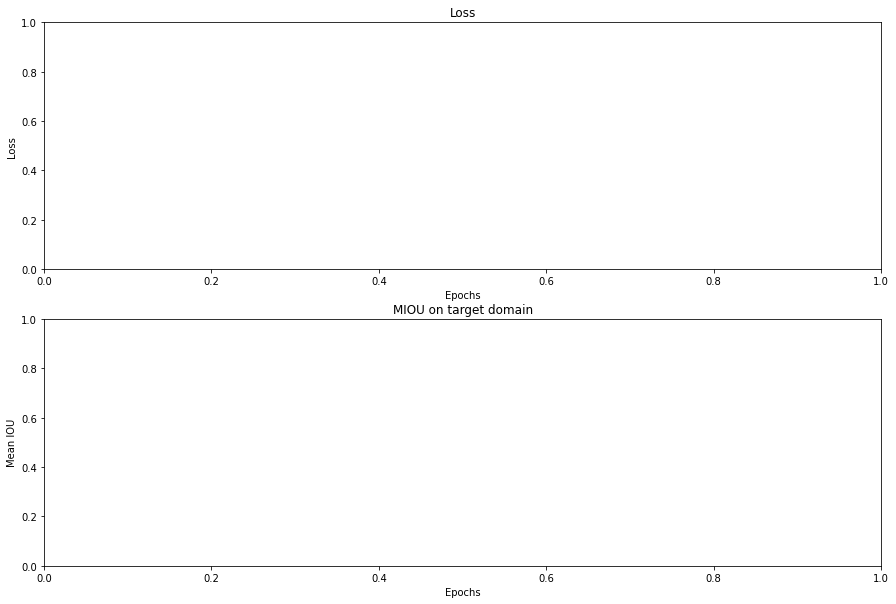

In [12]:
# active learning
# w/o  wasserstein loss
# Adam loss
# source clusters
import math 
fig, ax=plt.subplots(2, figsize=(15,10))

batch_size = 20

thres = .99
epochs2 = 20
epochstep = 2


# active learning set up 
ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, num_classes, 256)
print("Loaded cluster centroids for active learning")
print(cluster_centroids.shape)

best_miou = -math.inf
best_ious = []
active_learning = True
strategy = "ours"
all_selected_idx = []
for itr in range(epochs2):
    
    if itr%epochstep == 0:
        print('Iteration: {}'.format(itr))
    
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    # target_train_labels_cat = tf.keras.utils.to_categorical(target_train_labels, num_classes=num_classes)
     
    if active_learning and strategy is not None:
        pred_target_labels = deeplabv3(target_train_data)

        X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_XY(target_train_data, pred_target_labels, target_train_labels, 256, batch_size, 0.2, num_classes, strategy = strategy)
        Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
        all_selected_idx.append(selected_idx)
    else:
        pass # TODO: run unsupervised method here

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)

    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
    
    # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, X_labeled, Y_labeled]))
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 14/13
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
        best_combined = combined_
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            print(ll)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1] * lambda2, label='active learning ce loss')
            ax[0].plot(ll[:,2] * lambda1, label='replay buffer ce loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        deeplabv3.save_weights(fn_w_adapted_dlv3)
        classifier.save_weights(fn_w_adapted_cls)
        
        time.sleep(1e-3) 
        
    if itr == epochs2 - 1:
        # run for best epoch
        best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_13, ids_to_ignore = all_selected_idx)
        for k in best_cat_iou:
            print(k, best_cat_iou[k])
        print(best_miou2)

In [10]:
# active learning
# .7 active learning .3 replay buffer
# w/o  wasserstein loss
# Adam loss
# source clusters
import math 
fig, ax=plt.subplots(2, figsize=(15,10))

# load model weights
deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')
print("Loaded model weights")

# load replay buffer params
means = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
means = np.nan_to_num(means)
covs = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
print("Loaded means and covariances for replay buffer")

batch_size = 20

thres = .99
epochs2 = 20
epochstep = 2


# active learning set up 
ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, num_classes, 256)
print("Loaded cluster centroids for active learning")
print(cluster_centroids.shape)

best_miou = -math.inf
best_ious = []
active_learning = True
strategy = "ours"
all_selected_idx = []
loss = []
target_miou = []

for itr in range(epochs2):
    
    if itr%epochstep == 0:
        print('Iteration: {}'.format(itr))
    
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    # target_train_labels_cat = tf.keras.utils.to_categorical(target_train_labels, num_classes=num_classes)
     
    if active_learning and strategy is not None:
        pred_target_labels = deeplabv3(target_train_data)

        X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_XY(target_train_data, pred_target_labels, target_train_labels, 256, batch_size, 0.1, num_classes, strategy = strategy)
        Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
        all_selected_idx.append(selected_idx)
    else:
        pass # TODO: run unsupervised method here

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)

    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
    
    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, X_labeled, Y_labeled]))
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 14/13
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
        best_combined = combined_
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            print(ll)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1] * lambda1, label='replay buffer ce loss')
            ax[0].plot(ll[:,2] * lambda2, label='active learning ce loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        deeplabv3.save_weights(fn_w_adapted_dlv3)
        classifier.save_weights(fn_w_adapted_cls)
        
        time.sleep(1e-3) 
        
    if itr == epochs2 - 1:
        # run for best epoch
        best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_13, ids_to_ignore = all_selected_idx)
        for k in best_cat_iou:
            print(k, best_cat_iou[k])
        print(best_miou2)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x15538b537400> (for post_execute):


KeyboardInterrupt: 

mIoU at 19 epochs: 0.27941320034173817, best mIoU: 0.34360525699762196
ignore 0.0
road 0.7947118816096556
sidewalk 0.16950489943124855
building 0.5743483505290082
traffic light 0.14107658747600407
traffic sign 0.008417780324936393
vegetation 0.09634747227249862
sky 0.8953033105324258
person 0.17757578623261971
rider 0.0
car 0.8397632815376592
bus 0.007852661616903418
motorcycle 0.0
bicycle 0.0
0.26463585796878286


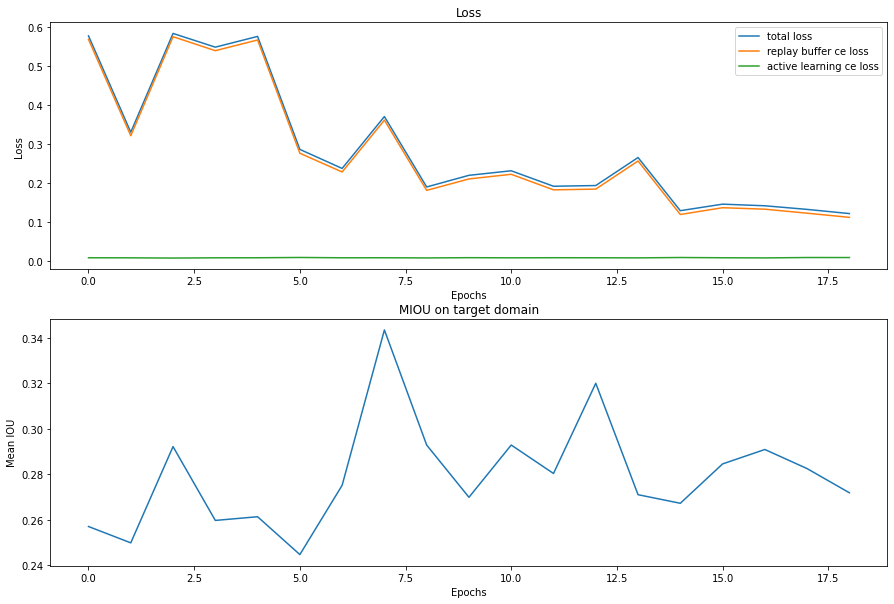

In [21]:
# active learning
# .99 active learning .01 replay buffer
# w/o  wasserstein loss
# source clusters
import math 
fig, ax=plt.subplots(2, figsize=(15,10))

# load model weights
deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')
print("Loaded model weights")

# load replay buffer params
means = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
means = np.nan_to_num(means)
covs = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
print("Loaded means and covariances for replay buffer")

batch_size = 10

thres = .99
epochs2 = 20
epochstep = 2


# active learning set up 
ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, num_classes, 256)
print("Loaded cluster centroids for active learning")
print(cluster_centroids.shape)

best_miou = -math.inf
best_ious = []
active_learning = True
strategy = "ours"
all_selected_idx = []
loss = []
target_miou = []

for itr in range(epochs2):
    
    if itr%epochstep == 0:
        print('Iteration: {}'.format(itr))
    
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    # target_train_labels_cat = tf.keras.utils.to_categorical(target_train_labels, num_classes=num_classes)
     
    if active_learning and strategy is not None:
        pred_target_labels = deeplabv3(target_train_data)

        X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_XY(target_train_data, pred_target_labels, target_train_labels, 256, batch_size, 0.2, num_classes, strategy = strategy)
        Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
        all_selected_idx.append(selected_idx)
    else:
        pass # TODO: run unsupervised method here

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)

    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
    
    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, X_labeled, Y_labeled]))
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 14/13
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
        best_combined = combined_
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            print(ll)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1] * lambda1, label='replay buffer ce loss')
            ax[0].plot(ll[:,2] * lambda2, label='active learning ce loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        deeplabv3.save_weights(fn_w_adapted_dlv3)
        classifier.save_weights(fn_w_adapted_cls)
        
        time.sleep(1e-3) 
        
    if itr == epochs2 - 1:
        # run for best epoch
        best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_13, ids_to_ignore = all_selected_idx)
        for k in best_cat_iou:
            print(k, best_cat_iou[k])
        print(best_miou2)

KeyboardInterrupt: 

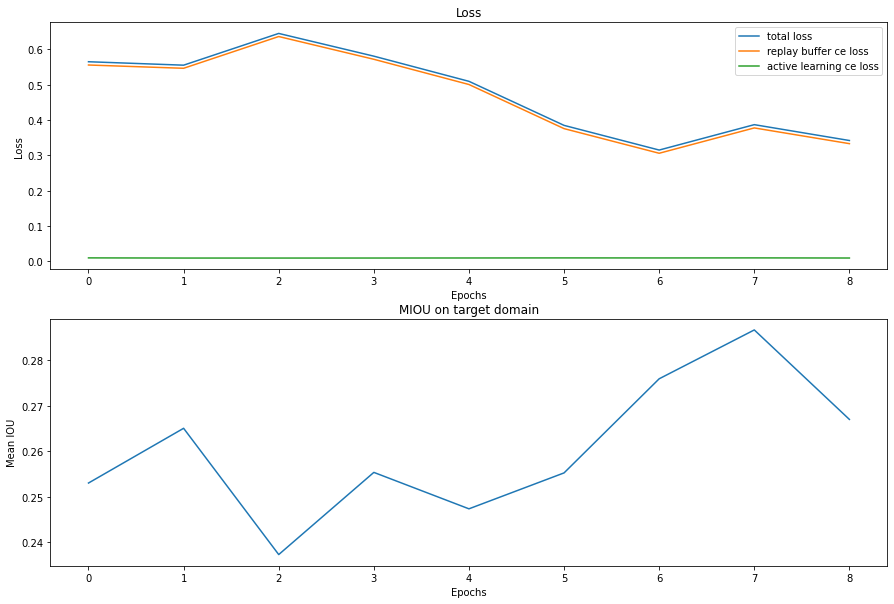

In [17]:
# active learning
# w/o wasserstein loss
# source clusters
import math 
fig, ax=plt.subplots(2, figsize=(15,10))

# load model weights
deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')
print("Loaded model weights")

# load replay buffer params
means = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/means_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
means = np.nan_to_num(means)
covs = np.load("/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/extras/covs_1024x512_vgg16deeplabv3_SYNTHIA_VIPER_DENSE_13_1.npy")
print("Loaded means and covariances for replay buffer")

batch_size = 20

thres = .99
epochs2 = 20
epochstep = 2


# active learning set up 
ncentroids = 10
with open('/global/cscratch1/sd/saksman/accda/anchors/cluster_centroids_full_%d.pkl' % ncentroids, 'rb') as f: 
    cluster_centroids = pickle.load(f)
cluster_centroids = cluster_centroids.reshape(ncentroids, num_classes, 256)
print("Loaded cluster centroids for active learning")
print(cluster_centroids.shape)

best_miou = -math.inf
best_ious = []
active_learning = True
strategy = "ours"
all_selected_idx = []
loss = []
target_miou = []

for itr in range(epochs2):
    
    if itr%epochstep == 0:
        print('Iteration: {}'.format(itr))
    
    target_train_data, target_train_labels = utils.sample_batch(cityscapes_data_dir, batch_size=batch_size, seed=itr)
    # target_train_labels_cat = tf.keras.utils.to_categorical(target_train_labels, num_classes=num_classes)
     
    if active_learning and strategy is not None:
        pred_target_labels = deeplabv3(target_train_data)

        X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_XY(target_train_data, pred_target_labels, target_train_labels, 256, batch_size, 0.1, num_classes, strategy = strategy)
        Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
        all_selected_idx.append(selected_idx)
    else:
        pass # TODO: run unsupervised method here

    # make sure the #samples from gaussians match the distribution of the labels
    n_samples = np.zeros(num_classes, dtype=int)
    cls, ns = np.unique(target_train_labels, return_counts=True)
    for i in range(len(cls)):
        if cls[i] == 0:
            continue
        n_samples[cls[i]] = ns[i]

    if np.sum(n_samples) % np.prod(img_shape) != 0:
        remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

        aux = np.copy(n_samples) / np.sum(n_samples)
        aux *= remaining
        aux = np.floor(aux).astype('int')
        
        n_samples += aux

        # in case there are extra samples left, dump them on the highest represented class
        n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)

    Yembed,Yembedlabels = utils.sample_from_gaussians(means, covs, n_samples = n_samples)
    Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
    Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
    Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
    
    theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
    
    loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, X_labeled, Y_labeled]))
    miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 14/13
    target_miou.append(miou)
    
    if miou > best_miou:
        best_miou = miou
        best_combined = combined_
    
    print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

    if itr%epochstep==0:
        # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
        # the ignore class
        if itr != 0:
            ax[0].clear()
            
            ll = np.asarray(loss)
            print(ll)
            ax[0].plot(ll[:,0], label='total loss')
            ax[0].plot(ll[:,1] * lambda1, label='replay buffer ce loss')
            ax[0].plot(ll[:,2] * lambda2, label='active learning ce loss')
            ax[0].legend()
            
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        
        if itr != 0:
            ax[1].clear()
            ax[1].plot(np.asarray(target_miou))
        
        ax[1].set_title("MIOU on target domain")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Mean IOU")
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        deeplabv3.save_weights(fn_w_adapted_dlv3)
        classifier.save_weights(fn_w_adapted_cls)
        
        time.sleep(1e-3) 
        
    if itr == epochs2 - 1:
        # run for best epoch
        best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_13, ids_to_ignore = all_selected_idx)
        for k in best_cat_iou:
            print(k, best_cat_iou[k])
        print(best_miou2)

### Performance after adaptation

In [ ]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou(source_data_dir, combined_, data_utils.label_ids_13, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

# VIPER 1
# road 0.45548384569118733
# sidewalk 0.22908076309616884
# building 0.7231414831527551
# traffic light 0.13056876105257134
# traffic sign 0.10746477632561094
# vegetation 0.29910880116931143
# sky 0.7702276075574622
# person 0.3968236052300994
# rider 0.0012631338117709702
# car 0.3250214488701445
# bus 0.011364789604663108
# motorcycle 0.0014075893390935838
# bicycle 0.0013295668128586176
# 0.26556047474720745
# Computed SYNTHIA_VIPER_DENSE_13_1 mIoU in 701.9752759933472


In [ ]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_13, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed VIPER mIoU in', time.time() - start_time)

# VIPER-1
# road 0.8170088043832361
# sidewalk 0.33026286655816334
# building 0.632127644160952
# traffic light 0.4009491872069492
# traffic sign 0.006254310466994813
# vegetation 0.1306418583589563
# sky 0.8650156523569378
# person 0.19010653822990375
# rider 0.0
# car 0.8404013262102543
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.32405909137941136
# Computed VIPER mIoU in 18.68591570854187

# VIPER-2
# road 0.6166949852470773
# sidewalk 0.3787735571503562
# building 0.6049256780597033
# traffic light 0.186964255325101
# traffic sign 0.0008168001712463807
# vegetation 0.09151754024216284
# sky 0.8323521128681671
# person 0.47658649376653717
# rider 0.0
# car 0.8210425378196808
# bus 0.3683831960382732
# motorcycle 0.0
# bicycle 0.0
# 0.33677362743756195
# Computed VIPER 2 mIoU in 12.673284530639648

# VIPER-3
# road 0.7241212757775349
# sidewalk 0.20394133957802926
# building 0.4374052246162175
# traffic light 0.1886698588396244
# traffic sign 0.0013552072158326775
# vegetation 0.23934770268178143
# sky 0.8418698288550998
# person 1.9359460000129065e-05
# rider 0.0
# car 0.8522794354467441
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.26838532557468187
# Computed VIPER 3 mIoU in 9.569716215133667

# VIPER-4




In [ ]:
import utils
importlib.reload(utils)

deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_4/vgg16_deeplabv3_adapted.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_4/vgg16_deeplabv3_classifier_adapted.h5')

deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')

start_time = time.time()
source_cat_iou,source_miou = utils.compute_miou('./processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence010/', combined_, data_utils.label_ids_13, 0)
for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

In [ ]:
import utils
importlib.reload(utils)

deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_adapted.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_classifier_adapted.h5')


# deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
# classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')

for target_i in range(1,11):
    target_data_dir = '/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence' + str(target_i).rjust(3, '0') + '/'
    source_cat_iou,source_miou = utils.compute_miou(target_data_dir, combined_, data_utils.label_ids_13, [])
    # for k in source_cat_iou:
    #     print(k, source_cat_iou[k])
    print(target_i, '\t : \t', source_miou)


1 	 : 	 0.3912087963836125
2 	 : 	 0.3399949880875378
3 	 : 	 0.2981430084764967
4 	 : 	 0.32685762021034603


In [24]:
import utils
importlib.reload(utils)

deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_adapted.h5')
classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/SYNTHIA_VIPER_DENSE_13_1/vgg16_deeplabv3_classifier_adapted.h5')


# deeplabv3.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3.h5')
# classifier.load_weights('/global/cfs/cdirs/m3691/segmentation_datasets/fangjun/SYNTHIA_VIPER_COMBINED_13/vgg16_deeplabv3_classifier.h5')

for target_i in range(1,11):
    target_data_dir = './processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence' + str(target_i).rjust(3, '0') + '/'
    source_cat_iou,source_miou = utils.compute_miou(target_data_dir, combined_, data_utils.label_ids_13, 0)
    # for k in source_cat_iou:
    #     print(k, source_cat_iou[k])
    print(target_i, '\t : \t', source_miou)


1 	 : 	 0.3304527332435952
2 	 : 	 0.33019344797055583
3 	 : 	 0.2819066622949565
4 	 : 	 0.31654615749708054
5 	 : 	 0.3073701739865
6 	 : 	 0.3069781458418397
7 	 : 	 0.2667288525194096
8 	 : 	 0.24169105277904077
9 	 : 	 0.27019105419790657
10 	 : 	 0.24983465619512438


In [ ]:
loss = []
target_miou = []

In [20]:
prev_target_data_dir = '/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence' + str(target_i-1).rjust(3, '0') + '/'
target_data_dir = '/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence' + str(target_i).rjust(3, '0') + '/'

print('adapting to target domain {}'.format(target_i), '\t', prev_target_data_dir, '\t', target_data_dir)

# learn gaussians for the previous target domain   
start_time = time.time()
cur_means, _, cur_ct = utils.learn_gaussians_seq(prev_target_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13)
print("computed means in for target {}".format(target_i), time.time() - start_time)

start_time = time.time()
cur_means, cur_covs, cur_ct = utils.learn_gaussians_seq(prev_target_data_dir, deeplabv3, combined, batch_size, data_utils_new.label_ids_13, initial_means=cur_means)
print("finished training gaussians in", time.time() - start_time)

cur_means = np.nan_to_num(cur_means)

target_means.append(cur_means)
target_covs.append(cur_covs)

cur_epochs = max(epochs_target, epochs_target // (target_i - 1))
print('number of epochs for current iter : ', cur_epochs) 

adapting to target domain 2 	 /global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence001/ 	 /global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence002/
0
100
200
300
400
Image /global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence001/427_image.npy could not be processed
Image /global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence001/428_image.npy could not be processed
Image /global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence001/429_image.npy could not be processed
Image /global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Seq

In [ ]:
import data_utils_new
importlib.reload(utils)

dataset = "SYNTHIA_VIPER_DENSE_13_"

fig,ax=plt.subplots(2,figsize=(15,10))

batch_size = 20

thres = .99
epochs_target = 20
epochstep = 2

log_f = open("log.txt", "a")

starting_target = 2

best_miou = -math.inf
best_ious = []
active_learning = True
strategy = "ours"
all_selected_idx = []

for target_i in range(starting_target, 10):   

    for itr in range(epochs_target):
    
        if itr%epochstep == 0:
            print('Iteration: {}'.format(itr))
            
        for prev_target in range(0, target_i-1):            
           
            # target_train_data, target_train_labels = utils.sample_batch(target_data_dir, batch_size=batch_size, seed=itr)
            target_train_data, target_train_labels = utils.sample_batch(target_data_dir, batch_size=batch_size, seed=itr)
            
            if active_learning and strategy is not None:
                pred_target_labels = deeplabv3(target_train_data)

                X_labeled, Y_labeled, X_eval, Y_eval, selected_idx = get_active_XY(target_train_data, pred_target_labels, target_train_labels, 256, batch_size, 0.2, num_classes, strategy = strategy)
                Y_labeled = tf.keras.utils.to_categorical(Y_labeled, num_classes=num_classes)
                all_selected_idx.append(selected_idx)

            # make sure the #samples from gaussians match the distribution of the labels
            n_samples = np.zeros(num_classes, dtype=int)
            cls, ns = np.unique(target_train_labels, return_counts=True)
            for i in range(len(cls)):
                if cls[i] == 0:
                    continue
                n_samples[cls[i]] = ns[i]

            if np.sum(n_samples) % np.prod(img_shape) != 0:
                remaining = np.prod(img_shape[:-1]) - np.sum(n_samples) % np.prod(img_shape[:-1])

                aux = np.copy(n_samples) / np.sum(n_samples)
                aux *= remaining
                aux = np.floor(aux).astype('int')

                n_samples += aux

                # in case there are extra samples left, dump them on the highest represented class
                n_samples[np.argmax(n_samples)] += remaining - np.sum(aux)

            Yembed,Yembedlabels = utils.sample_from_gaussians(target_means[prev_target], target_covs[prev_target], n_samples = n_samples)
            Yembed = Yembed.reshape(-1, img_shape[0], img_shape[1], num_classes)
            Yembedlabels = Yembedlabels.reshape(-1, img_shape[0], img_shape[1])
            Yembedlabels = tf.keras.utils.to_categorical(Yembedlabels, num_classes=num_classes)
            
            # theta_instance = tf.keras.backend.variable(wasserstein_utils.generateTheta(num_projections,num_classes))
            loss.append(train(inputs=[target_train_data, Yembed, Yembedlabels, X_labeled, Y_labeled]))
            miou = combined_.evaluate(X_eval, Y_eval, verbose=False)[-1] * 14/13
            target_miou.append(miou)
            
            if miou > best_miou:
                best_miou = miou
                best_combined = combined_
    
            print("mIoU at {0} epochs: {1}, best mIoU: {2}".format(itr, miou, best_miou)) 

        if itr%epochstep==0:
            # Debug info. First, the mIoU. Second, the categorical CE loss (ignoring class weights and containing) 
            # the ignore class
            if itr != 0:
                ax[0].clear()

                ll = np.asarray(loss)
                ax[0].plot(ll[:,0], label='total loss')
                ax[0].plot(ll[:,1] * lambda2, label='active learning ce loss')
                ax[0].plot(ll[:,2] * lambda1, label='replay buffer ce loss')
                ax[0].legend()

            ax[0].set_title("Loss")
            ax[0].set_xlabel("Epochs")
            ax[0].set_ylabel("Loss")

            if itr != 0:
                ax[1].clear()
                ax[1].plot(np.asarray(target_miou))

            ax[1].set_title("MIOU on target domain")
            ax[1].set_xlabel("Epochs")
            ax[1].set_ylabel("Mean IOU")

            display.display(plt.gcf())
            display.clear_output(wait=True)
            
            
            fn_w_adapted_dlv3 = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + str(target_i) + "/" + backbone +"_deeplabv3_adapted.h5"
            fn_w_adapted_cls = "/global/cfs/cdirs/m3691/segmentation_datasets/tilek/mas3-continual_latest/weights/" + dataset + str(target_i) + "/" + backbone + "_deeplabv3_classifier_adapted.h5"
            
            # print(fn_w_adapted_dlv3, fn_w_adapted_cls)

            deeplabv3.save_weights(fn_w_adapted_dlv3)
            classifier.save_weights(fn_w_adapted_cls)

            time.sleep(1e-3)    
        
        if itr == epochs2 - 1:
            # run for best epoch
            best_cat_iou, best_miou2 = utils.compute_miou(cityscapes_data_dir, best_combined, data_utils.label_ids_13, ids_to_ignore = all_selected_idx)
            for k in best_cat_iou:
                print(k, best_cat_iou[k])
            print(best_miou2)
            
    print('completed adapting to target domain {}'.format(target_i), '\t', prev_target_data_dir, '\t', target_data_dir)

    # calculate mIoU
    start_time = time.time()
    cit_cat_iou,cit_miou = utils.compute_miou(target_data_dir, combined_, data_utils.label_ids_13, 0)
    for k in cit_cat_iou:
        print(k, cit_cat_iou[k])
    
    print(cit_miou)
    log_f.write(str(target_i) + ' : ' + str(cit_miou))    

    print('Computed VIPER {} mIoU in'.format(target_i), time.time() - start_time)
    
log_f.close()



Iteration: 0


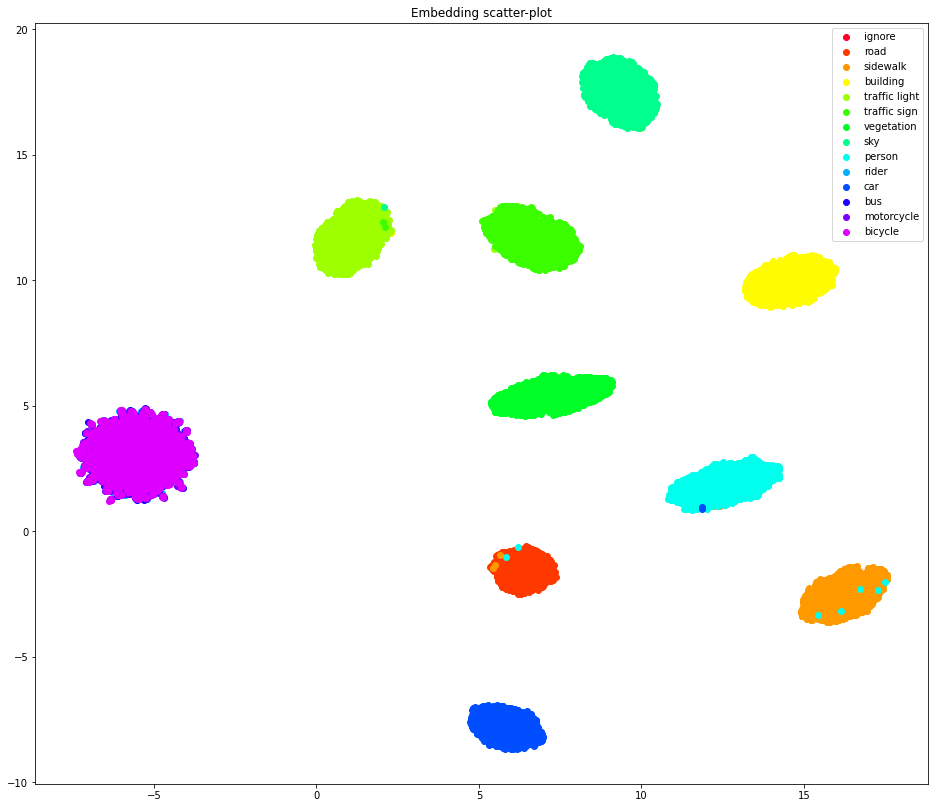

17.204325437545776


In [22]:
import data_utils_new
import matplotlib.pyplot as plt 
import umap.umap_ as umap
# Generate data from the gmm model and plot it

start_time = time.time()

n_samples = np.ones(num_classes, dtype=int)
n_samples[0] = 0
n_samples *= 2000

xx, yy = utils.sample_from_gaussians(means, covs, n_samples=n_samples)

NUM_COLORS = num_classes

reducer = umap.UMAP()

umap_embedding = reducer.fit_transform(xx)

plt.figure(figsize=(16,14))
cm = plt.get_cmap('gist_rainbow')

shift = 1 / len(data_utils_new.label_ids_13.keys())
idx = 0
for label in data_utils_new.label_ids_13:
    ind = yy == data_utils_new.label_ids_13[label]
    
    plt.scatter(umap_embedding[:,0][ind], umap_embedding[:,1][ind], label=label, \
                color=cm(1.*idx/NUM_COLORS))
    idx += 1

plt.title("Embedding scatter-plot")
plt.legend()
    
plt.show()

print(time.time() - start_time)

In [11]:
deeplabv3.load_weights(fn_w_adapted_dlv3)
classifier.load_weights(fn_w_adapted_cls)
print("Loaded model weights")

Loaded model weights


In [12]:
import utils
importlib.reload(utils)

start_time = time.time()

source_cat_iou,source_miou = utils.compute_miou('./processed-data/1024x512/13_classes/VIPER_DENSE_SEQ/Sequence001/', combined_, data_utils.label_ids_13, 0)

for k in source_cat_iou:
    print(k, source_cat_iou[k])
print(source_miou)

print('Computed ' + dataset + ' mIoU in', time.time() - start_time)

road 0.8308608968675483
sidewalk 0.27348768244553456
building 0.6513443882341332
traffic light 0.37291672961621636
traffic sign 0.0038099773782593166
vegetation 0.16323353477649255
sky 0.888175399577542
person 0.19304997344212002
rider 0.0
car 0.8840926390088035
bus 0.0
motorcycle 0.0
bicycle 0.0
0.32776701702666533
Computed SYNTHIA_VIPER_DENSE_13_1 mIoU in 159.04997277259827

0
100
200
300
400
road 0.8308608968675483
sidewalk 0.27348768244553456
building 0.6513443882341332
traffic light 0.37291672961621636
traffic sign 0.0038099773782593166
vegetation 0.16323353477649255
sky 0.888175399577542
person 0.19304997344212002
rider 0.0
car 0.8840926390088035
bus 0.0
motorcycle 0.0
bicycle 0.0
0.32776701702666533
Computed SYNTHIA_VIPER_DENSE_13_1 mIoU in 159.04997277259827


In [ ]:
# road 0.8615069121641106
# sidewalk 0.9000754476234025
# building 0.9430840666603088
# traffic light 0.5906668306793044
# traffic sign 0.4751323753940848
# vegetation 0.8432769737226227
# sky 0.9643724556369807
# person 0.7238095621515034
# rider 0.6191529188583779
# car 0.8826804768268254
# bus 0.9113284943230776
# motorcycle 0.6885963930665517
# bicycle 0.3477612301913242
# 0.7501110874844981
# Computed SYNTHIA_VIPER_DENSE_13 mIoU in 209.03599977493286

# VIPER1
# road 0.7598092688219289
# sidewalk 0.3371948453270736
# building 0.5888429412251485
# traffic light 0.2412746294793218
# traffic sign 0.007871538466283783
# vegetation 0.07906209988581193
# sky 0.8681167733611675
# person 0.15913067911219309
# rider 0.0
# car 0.8381470531819963
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.2984192176046866
# Computed SYNTHIA_VIPER_DENSE_13_2 mIoU in 12.690653085708618

# VIPER2
# road 0.12746921970993438
# sidewalk 0.01654514397536747
# building 0.08359767761356621
# traffic light 0.0014628747427203985
# traffic sign 0.0004797761683849531
# vegetation 0.0010155479171658137
# sky 0.06442882520719335
# person 1.3905304873809358e-05
# rider 0.0
# car 0.013538577154181806
# bus 0.0040766048179061275
# motorcycle 0.0
# bicycle 0.0
# 0.024048319431638026
# Computed SYNTHIA_VIPER_DENSE_13_3 mIoU in 16.93789768218994



In [11]:
start_time = time.time()

cit_cat_iou,cit_miou = utils.compute_miou(cityscapes_data_dir, combined_, data_utils.label_ids_13, 0)

for k in cit_cat_iou:
    print(k, cit_cat_iou[k])
print(cit_miou)

print('Computed VIPER mIoU in', time.time() - start_time)

# road 0.7883116582422506
# sidewalk 0.6215464735885322
# building 0.751691007583865
# wall 0.3993120030432491
# fence 0.39173486089325144
# pole 0.302509334397975
# traffic light 0.3019573318279201
# traffic sign 0.38603017233885695
# vegetation 0.7792104073113252
# terrain 0.484321694588526
# sky 0.8323752669785053
# person 0.5206867614087272
# rider 0.2377222662760571
# car 0.8020324193022697
# truck 0.4754062370048565
# bus 0.593789975462107
# train 0.5966522990567177
# motorcycle 0.3119814031424603
# bicycle 0.47793033593638945
# 0.5292211530728338
# Computed CITYSCAPES mIoU in 232.43373942375183

0
100
200
300
400
road 0.16361121759652467
sidewalk 5.5880594346001465e-06
building 0.0537824356711514
traffic light 0.004082077289533864
traffic sign 0.0
vegetation 0.004795258655464463
sky 0.03790733322264466
person 0.0
rider 0.0
car 0.02297664564513909
bus 0.0
motorcycle 0.0
bicycle 0.0
0.022089273549222518
Computed VIPER mIoU in 8.972235918045044


In [ ]:
# NO ADAPTATION

# road 0.4343089698314718
# sidewalk 0.11156745414108413
# building 0.3455360124643591
# traffic light 0.13244824374732939
# traffic sign 0.020891181218774212
# vegetation 0.16245698445827797
# sky 0.7351399630612382
# person 0.18702045190416963
# rider 0.0
# car 0.8301180914913947
# bus 0.06320265566955835
# motorcycle 0.0
# bicycle 0.0
# 0.23251461599905057
# Computed VIPER mIoU in 94.76635837554932

# ALL IN ONE

# road 0.6900469076232928
# sidewalk 0.3999559532819935
# building 0.4477707606588546
# traffic light 0.14471677916664455
# traffic sign 0.005208014396949388
# vegetation 0.22113673614692125
# sky 0.8054719866917823
# person 0.20232922242992005
# rider 0.0
# car 0.7608467046022307
# bus 0.5757047777388474
# motorcycle 0.0
# bicycle 0.0
# 0.32716829559518745
# Computed VIPER mIoU in 133.14108419418335

# SYNTHIA-VIPER1
# road 0.8153079075418371
# sidewalk 0.3638901684131552
# building 0.6422570606708572
# traffic light 0.3448658440152766
# traffic sign 0.030519858531548108
# vegetation 0.11682109473012166
# sky 0.86401077761864
# person 0.18156178781292293
# rider 0.0
# car 0.8640675468674487
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.32486938816936983
# Computed VIPER mIoU in 12.139243841171265


# VIPER1-VIPER2
# road 0.588499111128223
# sidewalk 0.369365725539779
# building 0.6204748941380721
# traffic light 0.1665936557512192
# traffic sign 0.01265457278785601
# vegetation 0.043019551365977134
# sky 0.8271666403331733
# person 0.3732262212752325
# rider 0.0
# car 0.816343619490096
# bus 0.02369959332673774
# motorcycle 0.0
# bicycle 0.0
# 0.29546489116433583
# Computed VIPER mIoU in 11.642083406448364

# VIPER2-VIPER3
# road 0.14499194020624828
# sidewalk 0.010885014754372853
# building 0.052795147047877924
# traffic light 0.00418806705772967
# traffic sign 0.0018961732294710642
# vegetation 0.006274219959573628
# sky 0.06364095194179961
# person 0.0
# rider 0.0
# car 0.013660761584344825
# bus 0.0
# motorcycle 0.0
# bicycle 0.0
# 0.022948636598570604
# Computed VIPER mIoU in 14.073742628097534



In [ ]:
deeplabv3.save_weights(fn_w_adapted_dlv3)
classifier.save_weights(fn_w_adapted_cls)

In [ ]:
deeplabv3.load_weights(fn_w_adapted_dlv3)
classifier.load_weights(fn_w_adapted_cls)